In [1]:
import numpy as np
import scipy as ci 
import pandas as pd 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from IPython.display import display, HTML
from sklearn.externals import joblib
from scipy import stats
from scipy.optimize import minimize

import seaborn as sns 
import random
import tables 
import pickle
import warnings
warnings.filterwarnings('once')

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

/Users/yang/miniconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
plt.figure()
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'font.size': 12})
plt.rc('axes', axisbelow=True)

<Figure size 432x288 with 0 Axes>

In [3]:
lifetime = 86400*365 # 1 year! 
fig_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/plots/syst-x-3-'
data_dir = '/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/'
plt.rcParams.update({'font.size': 14})
plt.rc('axes', axisbelow=True)

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


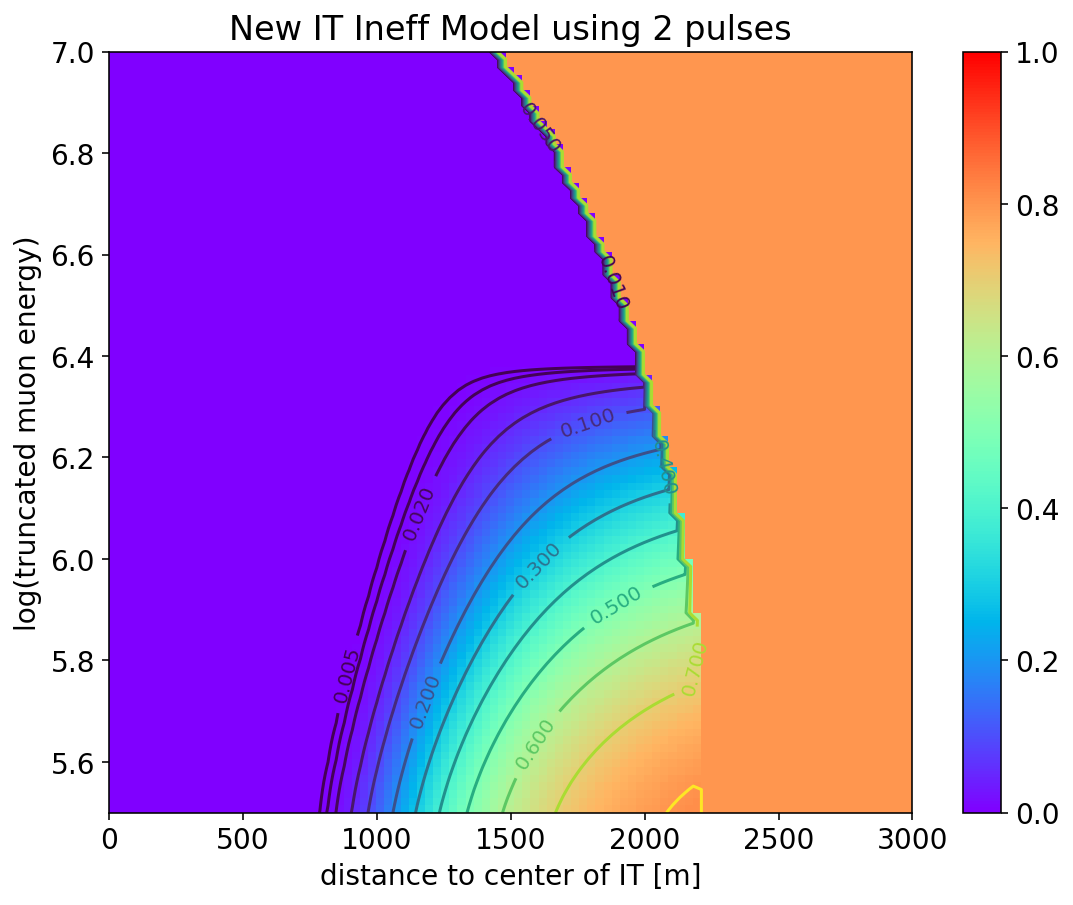

In [4]:
# OLD and NEW ineff model parameters 
params = np.loadtxt('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/1_distribution_plots/IT_model_robust_2.txt')

def ineff_model_new(dist,E): # E: log10 of energy!!! 
    
    a = params[0] * (E - params[1])**2 + params[2]
    b = params[3] * (E - params[4])**2 + params[5]

    val = a * np.exp(-b/(dist/2000)**(4.2)) # 2 pulse robust

    val[val < 1e-5] = 1e-5 # This is arbitrary! 

    # low stat cut 
    val[E > 5.47+2*np.sqrt(1 - ((dist-20)/2210)**2) ]=0.8
    val[dist > 2210] = 0.8
    return val

xt = np.linspace(0.001,3000,100) # dist 
yt = np.linspace(5.5,7,100)  # E 
xg,yg = np.meshgrid(xt,yt)
zg = ineff_model_new(xg,yg)

plt.figure(figsize=(9,7))
plt.pcolormesh(xg,yg,zg,cmap='rainbow',shading='flat')
plt.colorbar()
plt.clim(0,1) # colorbar limit
CS=plt.contour(xg,yg,zg,levels=[0.005,0.01,0.02,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
plt.clabel(CS,inline=1,fmt='%1.3f',fontsize=10)
plt.xlabel('distance to center of IT [m]')
plt.ylabel('log(truncated muon energy)')
plt.xlim(0,3000)
plt.ylim(5.5,7)
plt.title('New IT Ineff Model using 2 pulses')
plt.show()

In [5]:
# with tables.open_file(data_dir+'data_h5/data_burn.h5','r') as f:
with tables.open_file(data_dir+'data_h5/data_burn_new.h5','r') as f: # 8 years
    nfile_data = [2831731.134,3081951.304,3158084.037,3155703.188,3082765.564,3550407.43,3186599.156,2706824.349]

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1

    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_toposplit
    
    ineff_data_burn = ineff_[CUT]

    chi2_red_data_burn = f.root.Collection.cols.chi2_red[:][CUT]
    chi2_red_new_data_burn = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_data_burn = f.root.Collection.cols.PeakOverMedian[:][CUT]
    stoch_data_burn = (chi2_red_data_burn + (np.log10(PeakOverMedian_data_burn)/2))/np.sqrt(2)

    zenith_data_burn = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_data_burn = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_data_burn = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_data_burn = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_data_burn = f.root.QTot.cols.value[:][CUT]
    Qtot_data_burn = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_data_burn = f.root.Balloon.cols.N_Doms[:][CUT]
#     N_pulses_data_burn = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_data_burn = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]

    closest_d_data_burn = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_data_burn = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_data_burn = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_data_burn = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]

    IT_Npulse_data_burn = f.root.IT_veto_double.cols.num_Total_hits[:][CUT]
    Npulse_in_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_in_window[:][CUT]
    Npulse_off_window_data_burn = f.root.IT_veto_double.cols.num_correlated_Total_hits_off_window[:][CUT]

    passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
    vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    # IT TW cleaning
#     passed_2_data_burn = (f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) # 1 if passed 
#     vetoed_2_data_burn = (1 - f.root.IT_veto_double.cols.flag_window_2[:][CUT]).astype(bool) 
    
    
    runid_data_burn = f.root.I3EventHeader.cols.Run[:][CUT]
    eventid_data_burn = f.root.I3EventHeader.cols.Event[:][CUT]
    
    weight_data_burn = np.ones(len(zenith_data_burn))
#     weight_data_burn = lifetime/np.sum(nfile_data) * np.ones(len(zenith_data_burn))


/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


In [6]:
# with tables.open_file(data_dir+'corsika_h5/corsika_combined.h5','r') as f:
with tables.open_file(data_dir+'corsika_h5/corsika.h5','r') as f: # All

    ineff_ = ineff_model_new(f.root.Dist_to_IT_center.cols.value[:],np.log10(f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:]))

    CUT_dedx = f.root.Collection.cols.len_dEdxVector[:] >= 6
    CUT_cascllh = f.root.CascadeLlhVertexFitParams.cols.rlogL[:] < 18
    CUT_d_IC = f.root.Dist_to_IC_center.cols.value[:] < 450
    CUT_LdirC = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:] > 600
    CUT_balloon = f.root.Balloon.cols.InIceBalloonParameter[:] < 0.22
    CUT_toposplit = f.root.TologicalCounterSplitCount.cols.value[:] == 1
    CUT_coincident = f.root.PolyplopiaInfo.cols.Multiplicity[:] == 1
    
    CUT = CUT_dedx & CUT_cascllh & CUT_d_IC & CUT_LdirC & CUT_balloon & CUT_toposplit & CUT_coincident
    
    ineff_corsika = ineff_[CUT]
    chi2_corsika = f.root.Collection.cols.chi2[:][CUT]
    chi2_red_corsika = f.root.Collection.cols.chi2_red[:][CUT]
    stoch_corsika = f.root.Collection.cols.stoch[:][CUT]
    chi2_new_corsika = f.root.Collection.cols.chi2_new[:][CUT]
    chi2_red_new_corsika = f.root.Collection.cols.chi2_red_new[:][CUT]
    PeakOverMedian_corsika = f.root.Collection.cols.PeakOverMedian[:][CUT]
    PeakOverMean_corsika = f.root.Collection.cols.PeakOverMean[:][CUT]

    zenith_corsika = f.root.SplineMPE.cols.zenith[:][CUT]
    truncated_muon_e_corsika = f.root.SplineMPETruncatedEnergy_SPICEMie_BINS_Muon.cols.energy[:][CUT]
    len_dedx_corsika = f.root.Collection.cols.len_dEdxVector[:][CUT]
    cascllh_corsika = f.root.CascadeLlhVertexFitParams.cols.rlogL[:][CUT]
    NPE_corsika = f.root.QTot.cols.value[:][CUT]
    Qtot_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    N_dom_corsika = f.root.Balloon.cols.N_Doms[:][CUT]
    N_pulses_corsika = f.root.Balloon.cols.N_Pulses[:][CUT]
    balloon_corsika = f.root.Balloon.cols.InIceBalloonParameter[:][CUT]
    balloon_adjusted_corsika = f.root.Balloon.cols.InIceBalloonParameter_adjusted[:][CUT]
    in_ice_total_charge_corsika = f.root.Balloon.cols.InIceTotalCharge[:][CUT]
    in_ice_total_charge_reduced_corsika = f.root.Balloon.cols.InIceTotalCharge_reduced[:][CUT]
    ndirdoms_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_doms[:][CUT]
    ndirpulses_corsika = f.root.SplineMPEDirectHitsC.cols.n_dir_pulses[:][CUT]
    topocount_corsika = f.root.TologicalCounterSplitCount.cols.value[:][CUT]
    wimpcount_corsika = f.root.WIMPrecoTopoSplitSplitCount.cols.value[:][CUT]
    cv_ndoms_corsika = f.root.CVMultiplicity.cols.n_hit_doms[:][CUT]
    cv_npulses_corsika = f.root.CVMultiplicity.cols.n_pulses[:][CUT]
    
    closest_d_corsika = f.root.Closest_approach_dist_to_nearest_IT_dom.cols.value[:][CUT]
    d_to_IC_center_corsika = f.root.Dist_to_IC_center.cols.value[:][CUT]
    d_to_IT_center_corsika = f.root.Dist_to_IT_center.cols.value[:][CUT]
    Ldir_corsika = f.root.SplineMPEDirectHitsC.cols.dir_track_length[:][CUT]
#     coincident_corsika = f.root.MCPrimary_coincident.cols.value[:][CUT]
    coincident_corsika = f.root.PolyplopiaInfo.cols.Multiplicity[:][CUT]
    prim_e_corsika = f.root.PolyplopiaPrimary.cols.energy[:][CUT]
    
    E_bundle_corsika = f.root.Bundle.cols.MuonBundleEnergy_Ei[:][CUT]
    E_leading_muon_corsika = f.root.Bundle.cols.MostEnergeticMuonEnergy_i[:][CUT]
    singleness_corsika = f.root.Bundle.cols.Singleness_Ei[:][CUT]
    bsize_corsika = f.root.Bundle.cols.Size_Ei[:][CUT]
    xf_corsika = E_bundle_corsika/prim_e_corsika
    epsilon_corsika = E_leading_muon_corsika/prim_e_corsika
    E_shower_corsika = prim_e_corsika - E_bundle_corsika # surface shower
    
    runid_corsika = f.root.FileNumber.cols.value[:][CUT]
    eventid_corsika = f.root.FileNumber.cols.Event[:][CUT]
    
    A_corsika = f.root.PolyplopiaPrimary.cols.type[:][CUT]
    CUT_H = A_corsika == 2212
    CUT_He = A_corsika == 1000020040
    CUT_N= A_corsika == 1000070140
    CUT_Al = A_corsika == 1000130270
    CUT_Fe = A_corsika == 1000260560
    
    weight_corsika = f.root.Combined_Weight_H3a[:][CUT] * lifetime

    weight_corsika_H = np.sum(weight_corsika) * weight_corsika[CUT_H]/np.sum(weight_corsika[CUT_H])
    weight_corsika_He = np.sum(weight_corsika) * weight_corsika[CUT_He]/np.sum(weight_corsika[CUT_He])
    weight_corsika_N = np.sum(weight_corsika) * weight_corsika[CUT_N]/np.sum(weight_corsika[CUT_N])
    weight_corsika_Al = np.sum(weight_corsika) * weight_corsika[CUT_Al]/np.sum(weight_corsika[CUT_Al])
    weight_corsika_Fe = np.sum(weight_corsika) * weight_corsika[CUT_Fe]/np.sum(weight_corsika[CUT_Fe])

/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in sqrt
  
/Users/yang/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


# define template fitting

In [7]:
# fit for both P_bundle and P_single 
def fitting(_ineff, singleness_thres=0.8, truncated_bin = None, makeplot=True):

    # ----- initializing ----- # 

    INEFF = _ineff

    bins = np.arange(-2,4,0.1)
    single_threshold = singleness_thres # single: singleness > single_threshold. bundle: singleness < single_threshold. 
    
    if truncated_bin:
        cut_corsika = (ineff_corsika<INEFF) & (np.log10(truncated_muon_e_corsika)>truncated_bin[0]) & (np.log10(truncated_muon_e_corsika)<truncated_bin[1])
        cut_data = (ineff_data_burn<INEFF) & (np.log10(truncated_muon_e_data_burn)>truncated_bin[0]) & (np.log10(truncated_muon_e_data_burn)<truncated_bin[1])
    else:
        cut_corsika = (ineff_corsika<INEFF)
        cut_data = (ineff_data_burn<INEFF)
        truncated_bin = [r'$-\inf$','$\inf$']
    # ----- KDE for single/bundle/data distributions ----- #

    bs = (bins[1:]+bins[:-1])/2

    var_bundle = np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<single_threshold]
    var_single = np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold]
    var_data = np.log10(chi2_red_new_data_burn[cut_data])

    varweight_bundle = weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<single_threshold]
    varweight_single = weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold]

    bandwidth='scott'
    kernel_single = stats.gaussian_kde(var_single,weights=varweight_single,bw_method=bandwidth)
    kernel_bundle = stats.gaussian_kde(var_bundle,weights=varweight_bundle,bw_method=bandwidth)
    kernel_data = stats.gaussian_kde(var_data,bw_method=bandwidth)

    kde_single = kernel_single(bs)
    kde_bundle = kernel_bundle(bs)
    kde_data = kernel_data(bs)

    # ----- plot stochasticity distribution with KDE ----- # 
    
    if makeplot:
        plt.figure(figsize=(8,5))
        plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<single_threshold],bins=bins,density=True,label='bundle',color='dodgerblue')
        plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold],bins=bins,density=True,label='single',color='darkorange')
        plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
        plt.plot(bs,kde_single,label='KDE, single',ls='--',color='darkorange')
        plt.plot(bs,kde_bundle,label='KDE, bundle',ls='--',color='dodgerblue')
        plt.plot(bs,kde_data,label='KDE, data',ls='--',color='black')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.axvline(2,color='m',ls='--',label='bg region cut')
        plt.legend(prop={'size':10})
        plt.xlim(-2,4)
        # plt.semilogy()
        plt.xlabel('log10 chi2_red_new')
        plt.show()

        plt.figure(figsize=(8,5))
        plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]<single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]<single_threshold],bins=bins,density=True,label='bundle',color='dodgerblue')
        plt.hist(np.log10(chi2_red_new_corsika[cut_corsika])[singleness_corsika[cut_corsika]>single_threshold],histtype='step',weights=weight_corsika[cut_corsika][singleness_corsika[cut_corsika]>single_threshold],bins=bins,density=True,label='single',color='darkorange')
        plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),histtype='step',bins=bins,color='black',density=True,label='data')
        plt.plot(bs,kde_single,label='KDE, single',ls='--',color='darkorange')
        plt.plot(bs,kde_bundle,label='KDE, bundle',ls='--',color='dodgerblue')
        plt.plot(bs,kde_data,label='KDE, data',ls='--',color='black')
        plt.axvline(2,color='m',ls='--',label='bg region cut')
        plt.legend(prop={'size':10},loc='upper left')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.xlim(-2,4)
        plt.ylim(1e-6,)
        plt.semilogy()
        plt.xlabel('log10 chi2_red_new')
        plt.show()

    # ----- LLH fit for best-fit bundle (y) & single (1-y) template normalization ----- # 

    def llh(y):
        exp = y*kde_bundle + (1-y)*kde_single

        obs = kde_data
        cut = (exp>0) & (obs>0) & (bs < 2) # only use bg region
        exp = exp[cut]
        obs = obs[cut]

        lnL = np.log(exp)*obs - exp - (obs*np.log(obs) - obs)
        return - np.sum(lnL)

    t = np.arange(0,1,0.001)
    ls = []
    for i in t:
        ls.append(llh(i))
    ls = np.array(ls)
    y_best = t[ls==np.min(ls)][0]
    
    if makeplot:
        # ----- plot LLH curve ----- # 
        plt.figure(figsize=(8,5))
        plt.plot(t,ls)
        plt.axvline(y_best,ls='--',label='best y: '+str(np.round(y_best,3)),color='black')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.xlabel('fraction of bundle distribution')
        plt.ylabel('-lnL')
        plt.legend()
        plt.show()

        # ----- plot new stochasticity template distributions ----- # 

        plt.figure(figsize=(8,5))
        plt.plot(bs,kde_bundle*y_best,'--',label='KDE bundle',color='dodgerblue')
        plt.plot(bs,kde_single*(1-y_best),'--',label='KDE single',color='darkorange')
        plt.plot(bs,kde_data,'x',label='KDE data',color='black')
        plt.plot(bs,kde_bundle*y_best+kde_single*(1-y_best),'o-',label='fit',color='green')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.axvline(2,color='m',ls='--',label='bg region cut')
        plt.xlabel('log10 chi2_red_new')
        plt.legend(prop={'size':10},loc='upper right')
        plt.xlim(-2,4)
        plt.show()

        plt.figure(figsize=(8,5))
        plt.plot(bs,kde_bundle*y_best,'--',label='KDE bundle',color='dodgerblue')
        plt.plot(bs,kde_single*(1-y_best),'--',label='KDE single',color='darkorange')
        plt.plot(bs,kde_data,'x',label='KDE data',color='black')
        plt.plot(bs,kde_bundle*y_best+kde_single*(1-y_best),label='fit',color='green')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.axvline(2,color='m',ls='--',label='bg region cut')
        plt.xlabel('log10 chi2_red_new')
        plt.xlim(-2,4)
        plt.ylim(1e-5,)
        plt.yscale('log')
        plt.legend(prop={'size':10},loc='upper right')
        plt.show()

        # ----- plot data distribution ----- # 

        plt.figure(figsize=(8,5))
        plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),bins=bins,histtype='step',weights=weight_data_burn[cut_data],label='data burn, total',log=True,color='black')
        plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]],label='data burn, vetoed',log=True,color='steelblue')
        plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]],label='data burn, passed',log=True,color='darkorange')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.xlabel('log10 chi2_red_new')
        plt.ylabel('Number of events')
        plt.legend(prop={'size':9})
        plt.xlim(-2,4)
        plt.show()

    # ----- LLH for best P_bundle, P_single ----- # 

    def sigma(x,y): # x/y
        return weight_data_burn[0]*x/y * np.sqrt(1/x + 1/y)
    def sigma_log10(x,y): # log10(x/y)
        return weight_data_burn[0]/np.log(10) * np.sqrt(1/x + 1/y)

    h_tot,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data]),bins=bins,weights=weight_data_burn[cut_data]) 
    h_veto,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[vetoed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][vetoed_2_data_burn[cut_data]]) 
    h_pass,b_ = np.histogram(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]]) 

    cut_nonzero = (h_pass>0)
    b_ = (b_[1:]+b_[:-1])/2
    b_=b_[cut_nonzero]
#     h_veto=h_veto[cut_nonzero]
    h_tot=h_tot[cut_nonzero]
    h_pass=h_pass[cut_nonzero]
    pass_ratio = h_pass/h_tot
    err_pass = sigma(h_pass,h_tot)
    err_pass_log10 = sigma_log10(h_pass,h_tot)

    # --- do likelihood fit to find best passing probabilities P_bundle and P_single --- # 
    
    h_sum = y_best*kde_bundle + (1-y_best)*kde_single

    def LS(X): # fit 2 params simultaneously
        Pb = X[0]
        Ps = X[1]
        
        exp = ( (y_best*kde_bundle/h_sum*Pb + (1-y_best)*kde_single/h_sum*Ps) )[cut_nonzero] # fit for PASSING probability

        obs = pass_ratio 
        err = err_pass
        
        ls = np.sum(((exp-obs)**2/err**2)[b_<2])
        return ls
    
    sol = minimize(LS,x0=[0.01,0.01]).x
    P_bundle = sol[0]
    P_single = sol[1]
    
    print('red chisqr val at best-fit:',LS([P_bundle,P_single])/(len(b_[b_<2])-2))
    print('P_bundle: {}, P_single: {}'.format(P_bundle,P_single))

    p_passing_best = (y_best*kde_bundle/h_sum*P_bundle + (1-y_best)*kde_single/h_sum*P_single)  # P_i: PASSING probability
    
    def fp(s,a,b,c,d): # smoothen the passing probability curve in log space
        return a*np.tanh(d*(s-b))+c
    popt,pcov = curve_fit(fp,bs[(bs>0)&(bs<2.5)],np.log10(p_passing_best)[(bs>0)&(bs<2.5)])
    
    h_proj = h_tot * 10**fp(b_,*popt) # project toal number of events to muon bgs 

    # --- plot passing fraction fitting results --- # 
    if makeplot:
        plt.figure(figsize=(8,5))
        t = np.arange(-2,4,0.01)
        plt.errorbar(b_,pass_ratio,fmt='.',yerr=err_pass,capsize=3,color='black')
        plt.plot(bs, p_passing_best,'o-',label='LLH fit')
        plt.plot(t,10**fp(t,*popt),label='smooth LLH fit')
        plt.axvline(2,color='m',ls='--',label='bg region cut')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.xlim(-2,4)
        plt.ylim(-0.05,0.4)
        plt.xlabel('log10 chi2_red_new')
        plt.ylabel('passing fraction')
        plt.legend()

        plt.figure(figsize=(8,5))
        t = np.arange(-2,4,0.01)
        plt.errorbar(b_,np.log10(pass_ratio),fmt='.',yerr=err_pass_log10,capsize=3,color='black')
        plt.plot(bs, np.log10(p_passing_best),'o-',label='LLH fit')
        plt.plot(t,fp(t,*popt),label='smooth LLH fit')
        plt.axvline(2,color='m',ls='--',label='bg region cut')
        plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.xlim(-2,4)
        plt.xlabel('log10 chi2_red_new')
        plt.ylabel('log10 passing fraction')
        plt.legend()
        plt.show()

        # ----- check projected bgs ----- # 

        plt.figure(figsize=(8,5))
        plt.hist(np.log10(chi2_red_new_data_burn[cut_data])[passed_2_data_burn[cut_data]],bins=bins,histtype='step',weights=weight_data_burn[cut_data][passed_2_data_burn[cut_data]],label='data burn, passed',log=True,color='darkorange',bottom=1e-4)
        plt.hist(np.log10(chi2_red_new_data_burn[cut_data]),bins=bins,histtype='step',weights=weight_data_burn[cut_data],label='data burn',log=True,color='black',bottom=1e-4)    
        plt.plot(b_,h_proj,'.',color='green',label='projected bg')
        plt.title(r'IT_ineff < {},  singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
        plt.xlabel('log10 chi2_red_new')
        plt.ylabel('Number of events')
        plt.legend(prop={'size':9})
        plt.xlim(-2,4)
        plt.ylim(1e-2,)
        plt.show()

    # ----- find s/b vs. stochasticity cut ----- # 
#     chi2cuts = np.arange(2,3.,0.1)
    
#     sigs = []
#     tots = []
#     sb_ratios = []

#     for cut in chi2cuts:
#         bg = np.sum(h_proj[b_>cut])
#         obs = np.sum(h_pass[b_>cut])
#         sig = obs - bg
#         sb_ratio = sig/bg
        
#         sigs=np.append(sigs, sig)
#         tots=np.append(tots, obs)
#         sb_ratios=np.append(sb_ratios, sb_ratio)
    
#     # smoothen the curves 
#     def f_expo(x,a,b,c):
#         return a * np.exp(b*x)+c
#     def f_linear(x,a,b):
#         return a*x + b
#     def f_poly(x,a,b,c):
#         return a*(x-2)**2 + b*x + c
#     fit_dict = {}
#     try:
#         popt_sb_expo,_ = curve_fit(f_expo,chi2cuts[sb_ratios>0],sb_ratios[sb_ratios>0],sigma=sigma(sigs[sb_ratios>0],tots[sb_ratios>0]))
# #         chi2red_expo = np.sum((f_expo(chi2cuts[sb_ratios>0],*popt_sb_expo)-sb_ratios[sb_ratios>0])**2)/(len(sigs[sb_ratios>0])-3)
#         chi2red_expo = np.sum((f_expo(chi2cuts[sb_ratios>0],*popt_sb_expo)-sb_ratios[sb_ratios>0])**2/sigma(sigs[sb_ratios>0],tots[sb_ratios>0])**2)/(len(sigs[sb_ratios>0])-3)

#         fit_dict['expo'] = popt_sb_expo
#         fit_dict['expo_chi2'] = chi2red_expo
#         fit_dict['expo_function'] = f_expo
#         fit_dict['expo_color'] = 'red'
#     except:
#         pass
    
#     try:
#         popt_sb_linear,_ = curve_fit(f_linear,chi2cuts[sb_ratios>0],sb_ratios[sb_ratios>0],sigma=sigma(sigs[sb_ratios>0],tots[sb_ratios>0]))
# #         chi2red_linear = np.sum((f_linear(chi2cuts[sb_ratios>0],*popt_sb_linear)-sb_ratios[sb_ratios>0])**2)/(len(sigs[sb_ratios>0])-2)
#         chi2red_linear = np.sum((f_linear(chi2cuts[sb_ratios>0],*popt_sb_linear)-sb_ratios[sb_ratios>0])**2/sigma(sigs[sb_ratios>0],tots[sb_ratios>0])**2)/(len(sigs[sb_ratios>0])-2)

#         fit_dict['linear'] = popt_sb_linear
#         fit_dict['linear_chi2'] = chi2red_linear
#         fit_dict['linear_function'] = f_linear
#         fit_dict['linear_color'] = 'darkorange'
#     except:
#         pass
    
#     try:
#         popt_sb_poly,_ = curve_fit(f_poly,chi2cuts[sb_ratios>0],sb_ratios[sb_ratios>0],sigma=sigma(sigs[sb_ratios>0],tots[sb_ratios>0]))
# #         chi2red_poly = np.sum((f_poly(chi2cuts[sb_ratios>0],*popt_sb_poly)-sb_ratios[sb_ratios>0])**2)/(len(sigs[sb_ratios>0])-3)
#         chi2red_poly = np.sum((f_poly(chi2cuts[sb_ratios>0],*popt_sb_poly)-sb_ratios[sb_ratios>0])**2/sigma(sigs[sb_ratios>0],tots[sb_ratios>0])**2)/(len(sigs[sb_ratios>0])-3)

#         fit_dict['poly'] = popt_sb_poly
#         fit_dict['poly_chi2'] = chi2red_poly
#         fit_dict['poly_function'] = f_poly
#         fit_dict['poly_color'] = 'green'
#     except:
#         pass
    
#     names = []
#     chi2s = []
#     models = ['expo', 'linear', 'poly']
#     for i in models:
#         if i in fit_dict.keys():
#             names=np.append(names,i)
#             chi2s=np.append(chi2s,fit_dict[i+'_chi2'])
    
#     best_one = names[chi2s==np.min(chi2s)]
#     print(best_one)
#     if makeplot: 
#         plt.figure(figsize=(8,5))
#         plt.plot(chi2cuts,sigs,'o-',label='total - proj. bg')
#         plt.plot(chi2cuts,tots,'o-',label='total')
#         plt.title(r'IT_ineff < {},  singleness @ {}, $E_\mu \in$[{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
#         plt.xlabel('log10(chi2_red_new) cut')
#         plt.ylabel('number of events in signal region')
#         plt.legend()
#         plt.xlim(2,3)
#         plt.ylim(0,)

#         plt.figure(figsize=(8,5))
# #         plt.plot(chi2cuts,sb_ratios,'o-',label='S/B')
#         plt.errorbar(chi2cuts[sb_ratios>0],sb_ratios[sb_ratios>0],yerr=sigma(sigs[sb_ratios>0],tots[sb_ratios>0]),fmt='o-',capsize=3)
    
#         t = np.arange(2,np.max(chi2cuts),0.01)
#         for i in names: #'expo', 'linear', 'poly'
#             plt.plot(t,fit_dict[i+'_function'](t,*fit_dict[i]),label=r'fitted S/B, '+i+', $\chi^2_{red}$='+str(np.round(fit_dict[i+'_chi2'],2)),color=fit_dict[i+'_color'])

# #         try:
# #             plt.plot(np.arange(2,np.max(chi2cuts),0.01),f_expo(np.arange(2,np.max(chi2cuts),0.01),*popt_sb_ratios),label=r'fitted S/B, expo, $\chi^2_{red}$='+str(np.round(chi2red_expo,2)),color='darkorange')
# #             plt.plot(np.arange(2,np.max(chi2cuts),0.01),f_linear(np.arange(2,np.max(chi2cuts),0.01),*popt_sb_linear),label=r'fitted S/B, linear,  $\chi^2_{red}$='+str(np.round(chi2red_linear,2)),color='green')
# #         except: 
# #             plt.plot(np.arange(2,np.max(chi2cuts),0.01),f_linear(np.arange(2,np.max(chi2cuts),0.01),*popt_sb_linear),label=r'fitted S/B, linear,  $\chi^2_{red}$='+str(np.round(chi2red_linear,2)).format(chi2red_linear),color='green')

#         plt.title(r'IT_ineff < {}, singleness @ {}, $E_\mu \in$ [{},{}]'.format(INEFF,single_threshold,truncated_bin[0],truncated_bin[1]))
#         plt.xlabel('log10(chi2_red_new) cut')
#         plt.ylabel('S/B')
#         plt.axhline(2,ls='--',color='black',label='S/B=2')
#         plt.xlim(2,3)
#         plt.legend()
#         plt.show()
    
    # ----- create output arrays ----- # 
    return fp, popt, b_, h_proj
#     if best_one == 'expo':
#         return chi2cuts, tots, sigs, f_expo(chi2cuts, *popt_sb_expo), f_expo, popt_sb_expo
#     elif best_one == 'linear':
#         return chi2cuts, tots, sigs, f_linear(chi2cuts, *popt_sb_linear), f_linear, popt_sb_linear
#     elif best_one == 'poly':
#         return chi2cuts, tots, sigs, f_poly(chi2cuts, *popt_sb_poly), f_poly, popt_sb_poly

<>:17: DeprecationWarning: invalid escape sequence \i


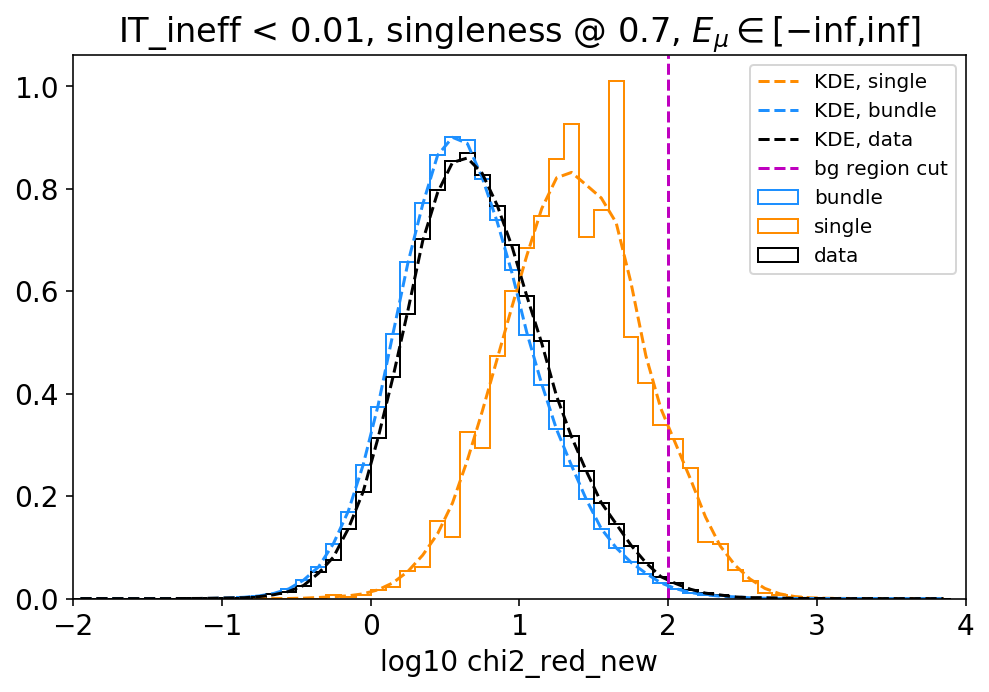

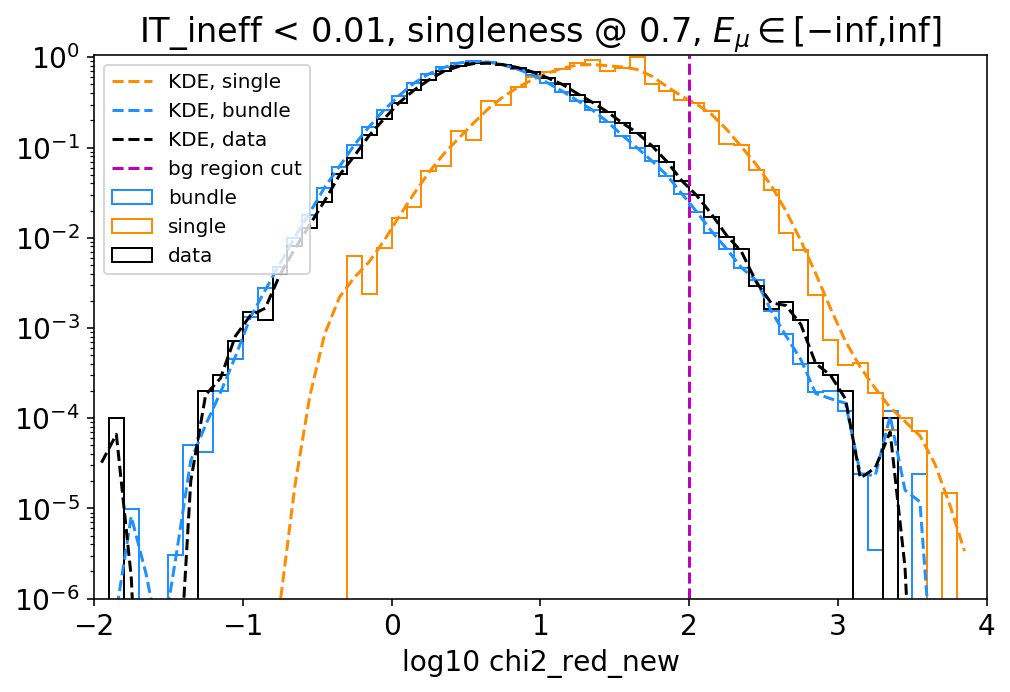

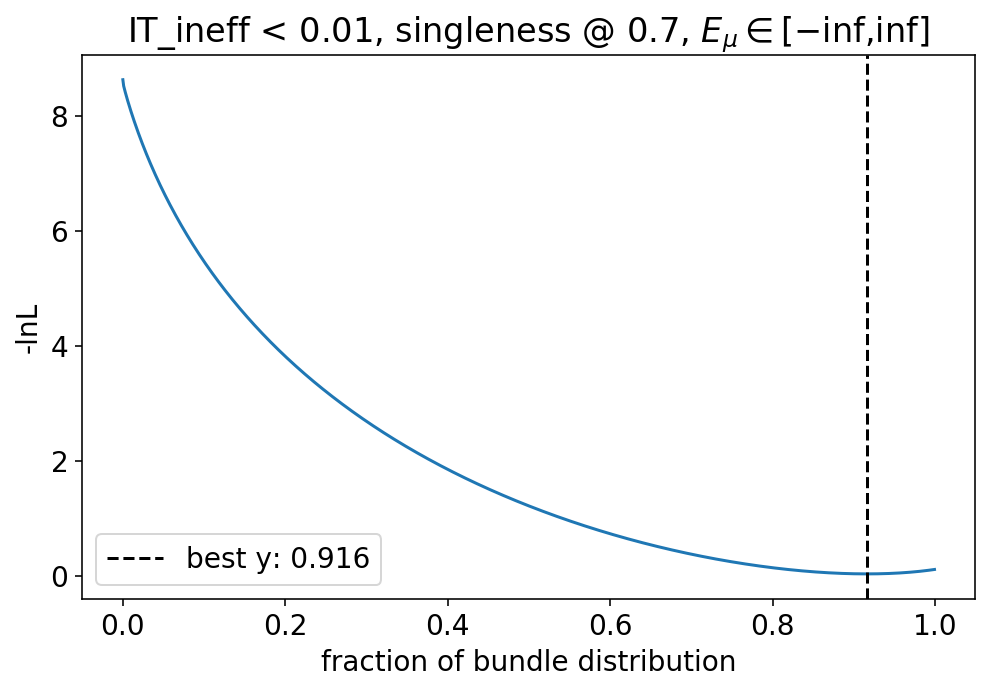

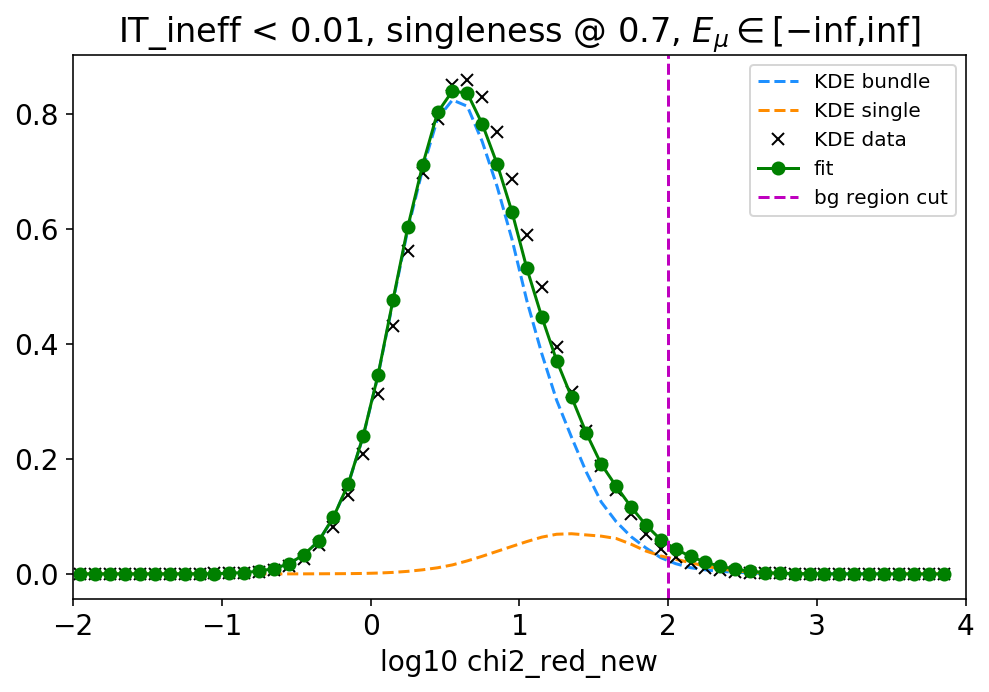

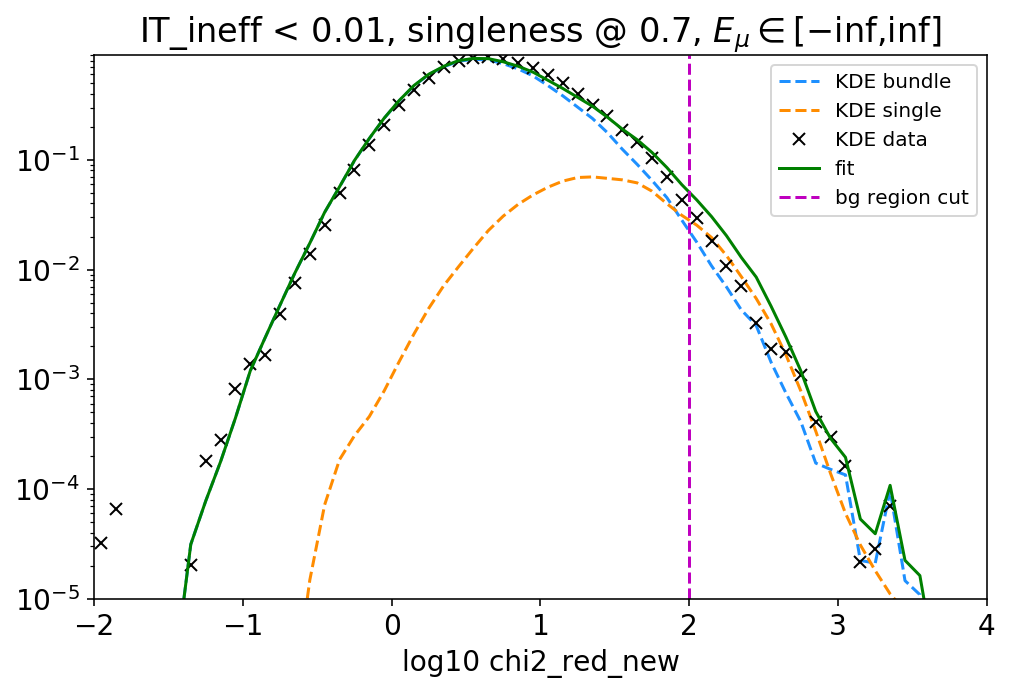

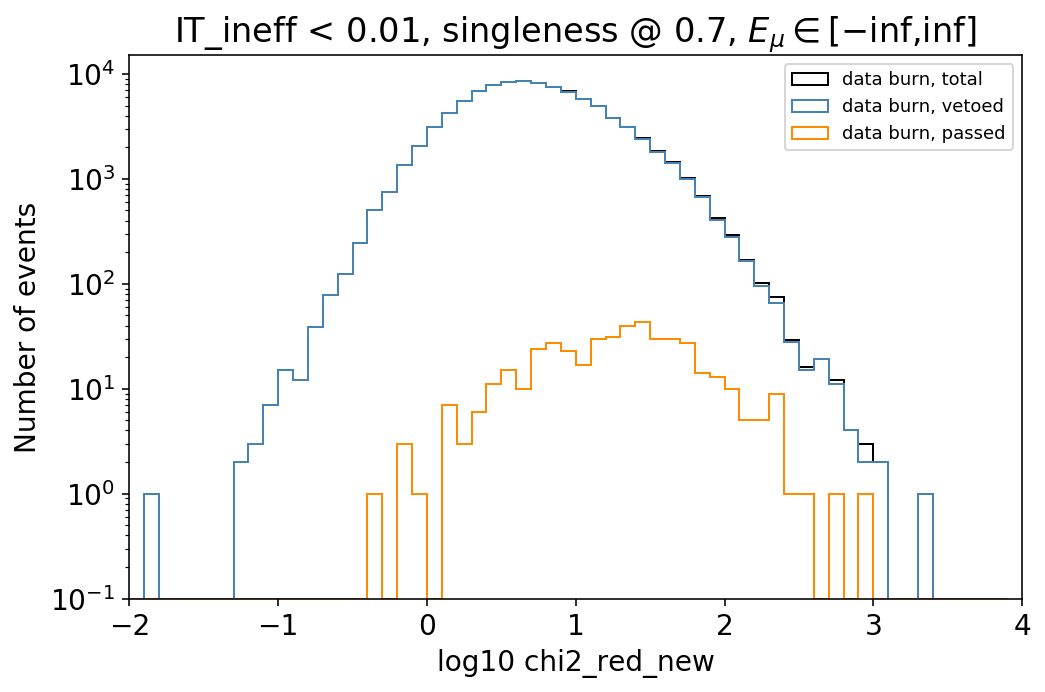

red chisqr val at best-fit: 1.4599239002697977
P_bundle: 0.000469335498502603, P_single: 0.04461080938283584


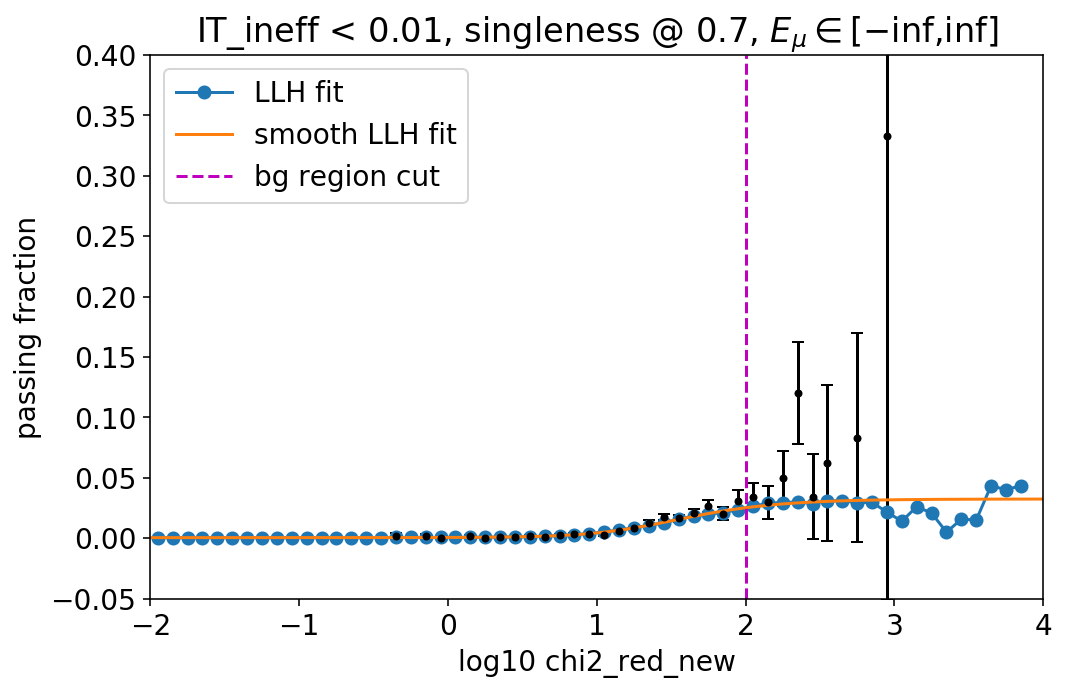

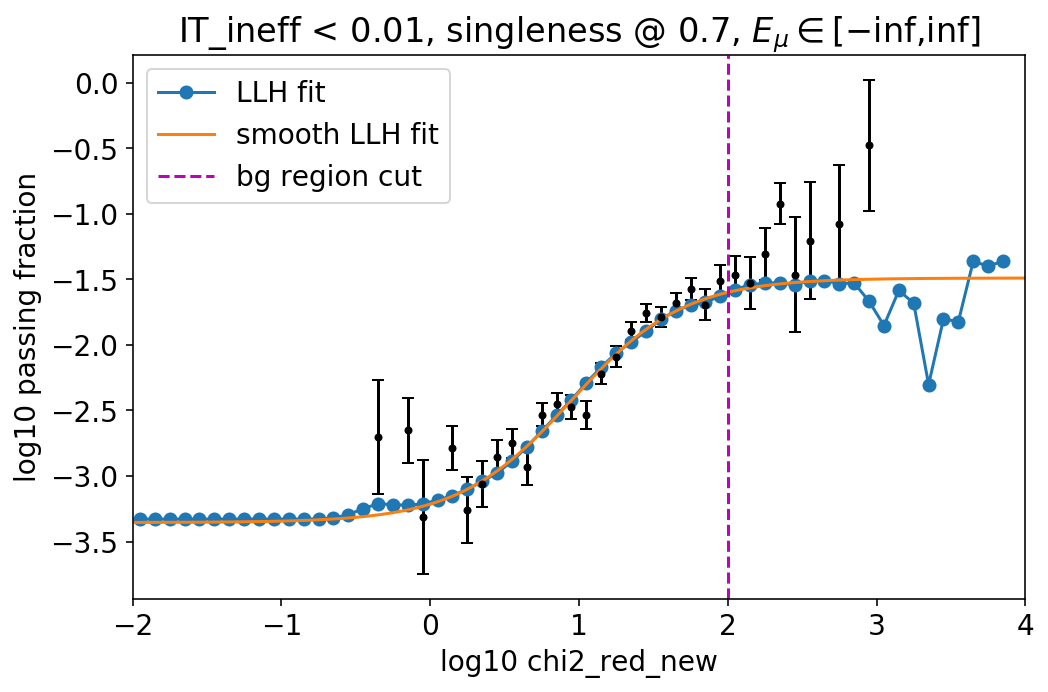

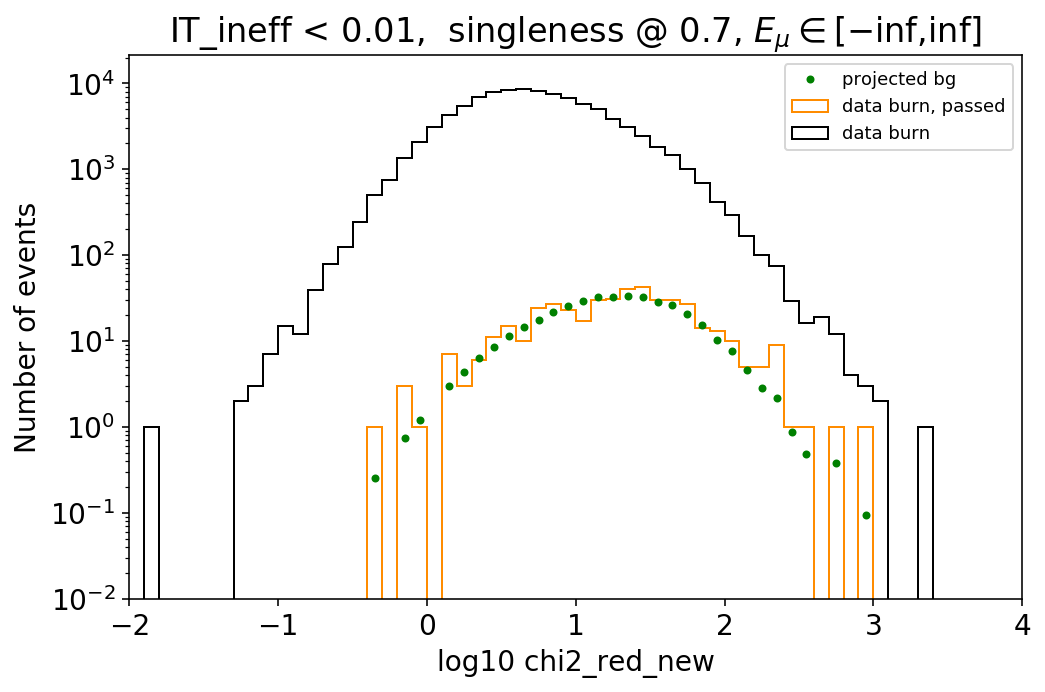

In [8]:
fp_07, popt_07, b_07, h_proj_07 = fitting(0.01,singleness_thres=0.7,makeplot=True)

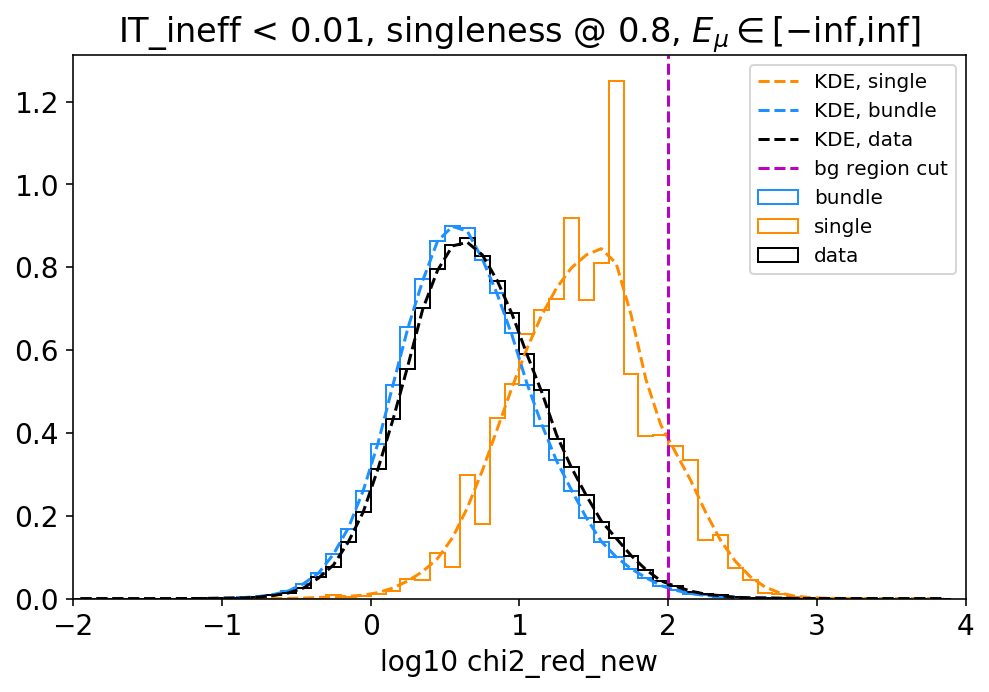

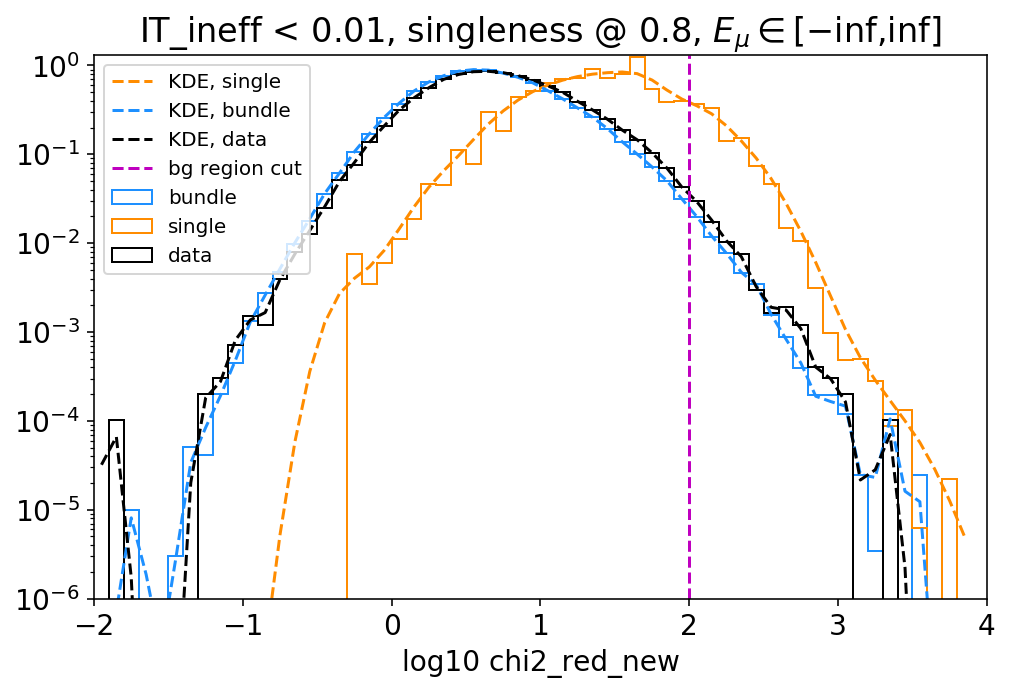

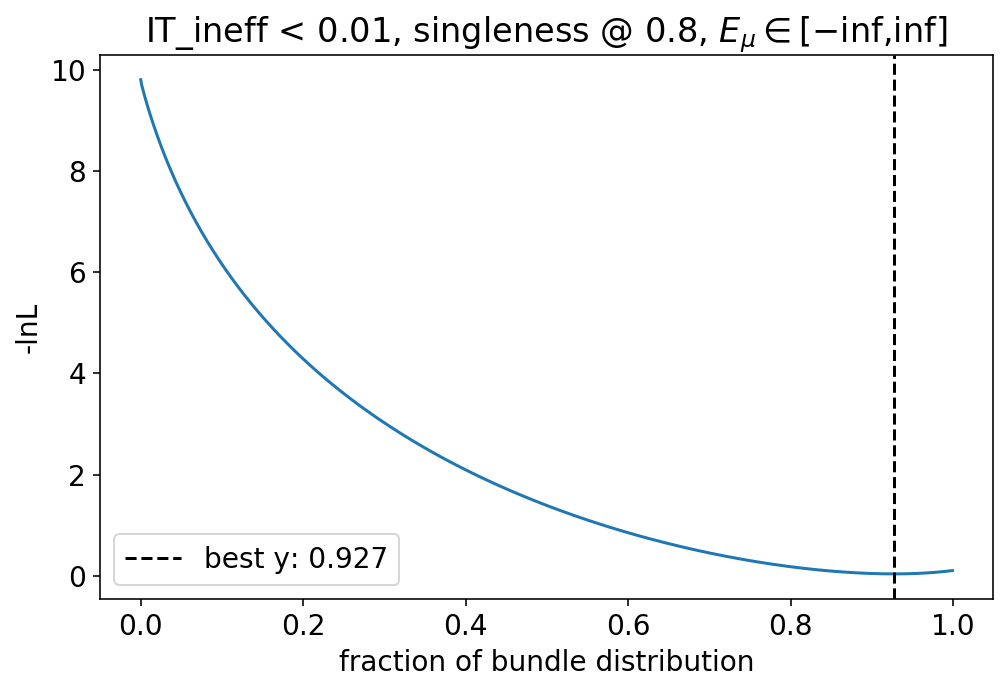

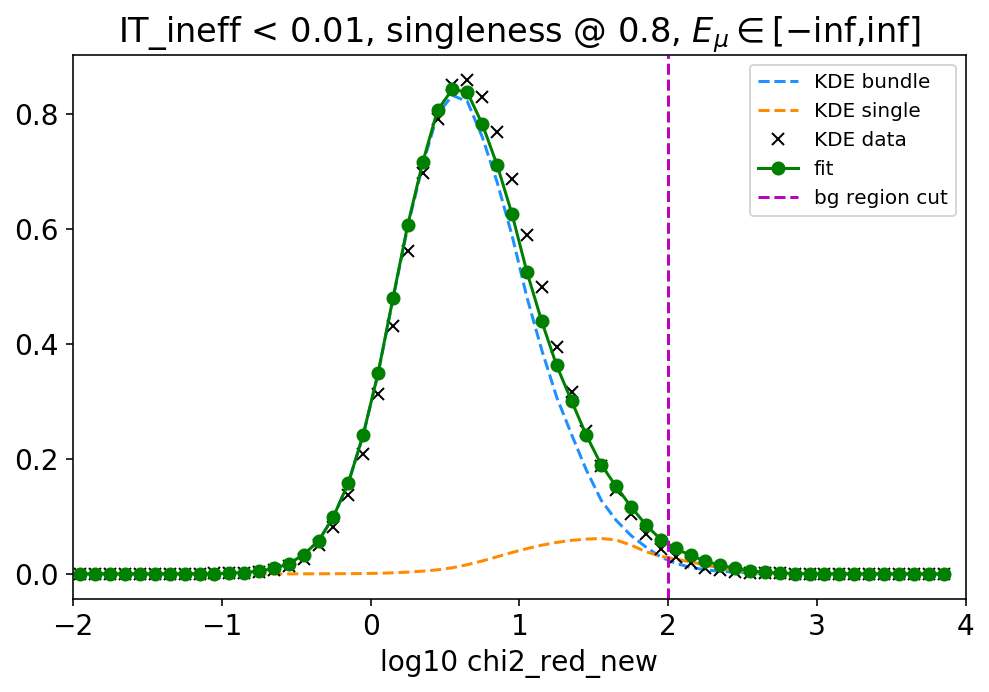

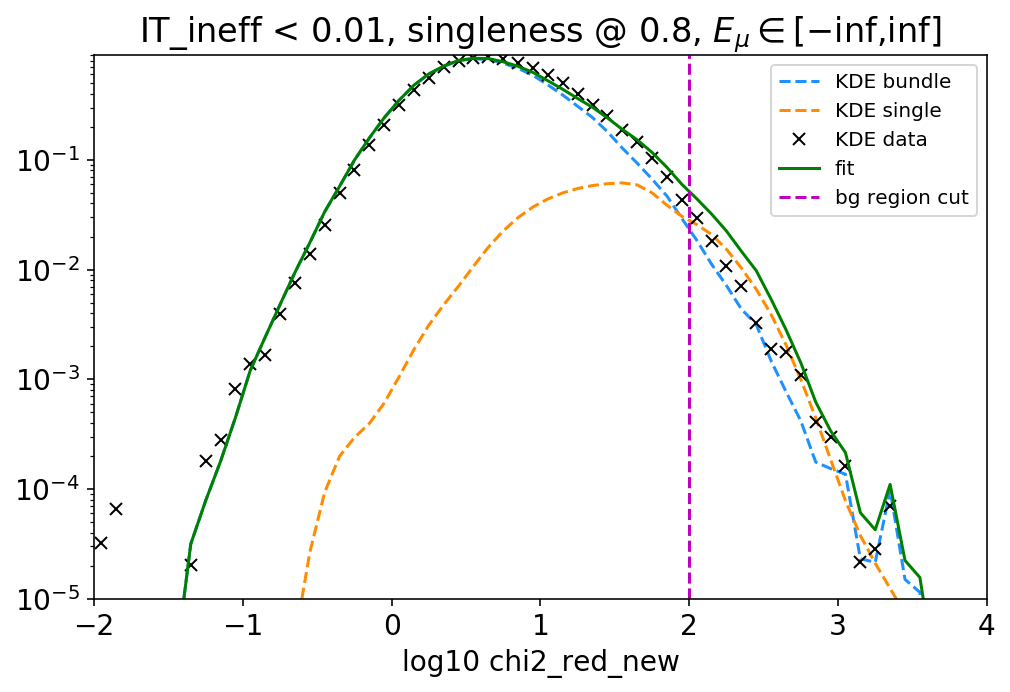

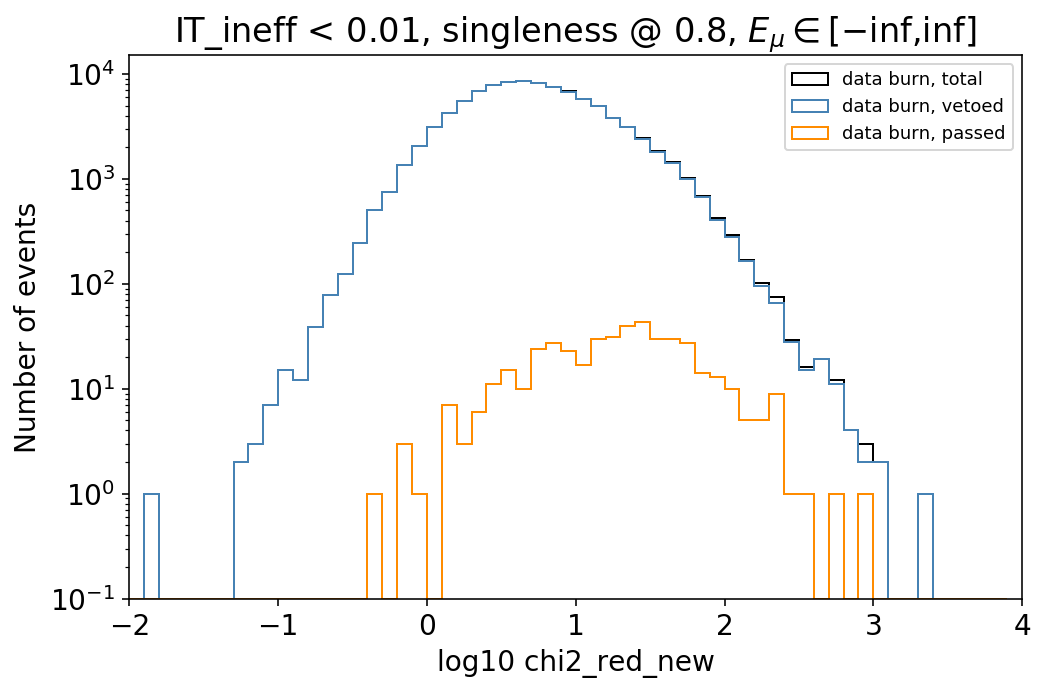

red chisqr val at best-fit: 1.2209604206522746
P_bundle: 0.0006172253040025152, P_single: 0.05143528879473211


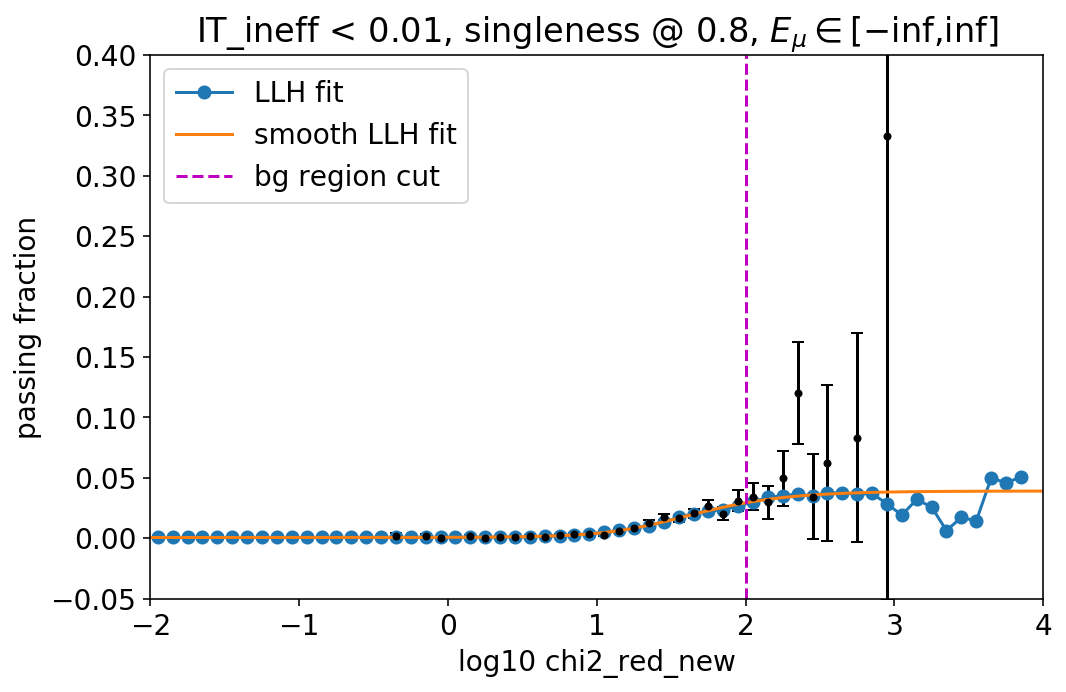

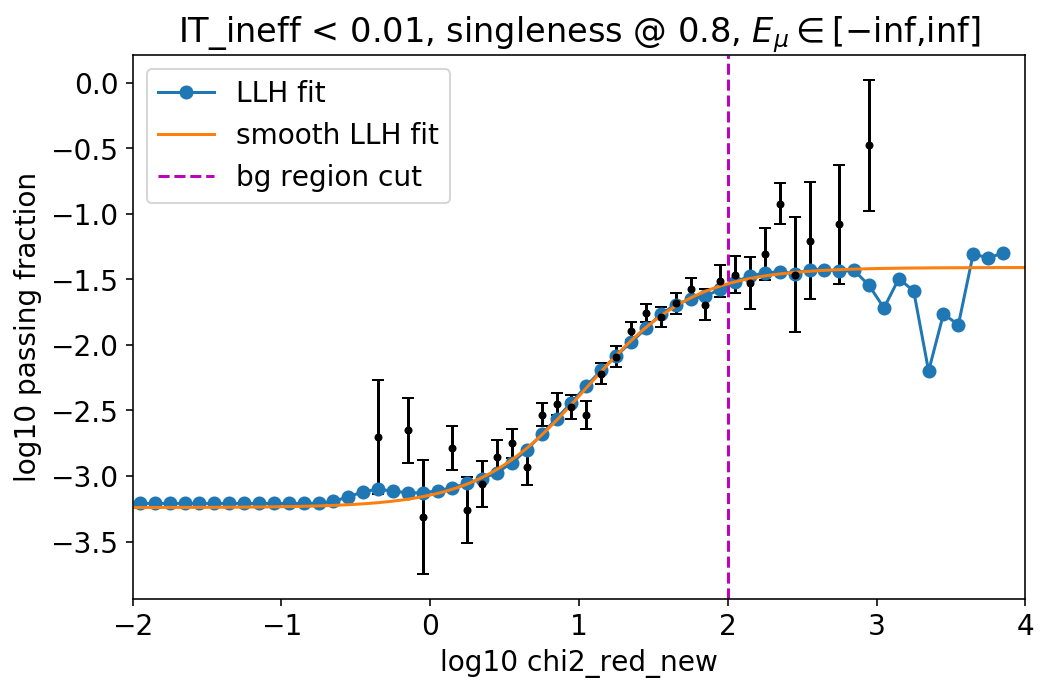

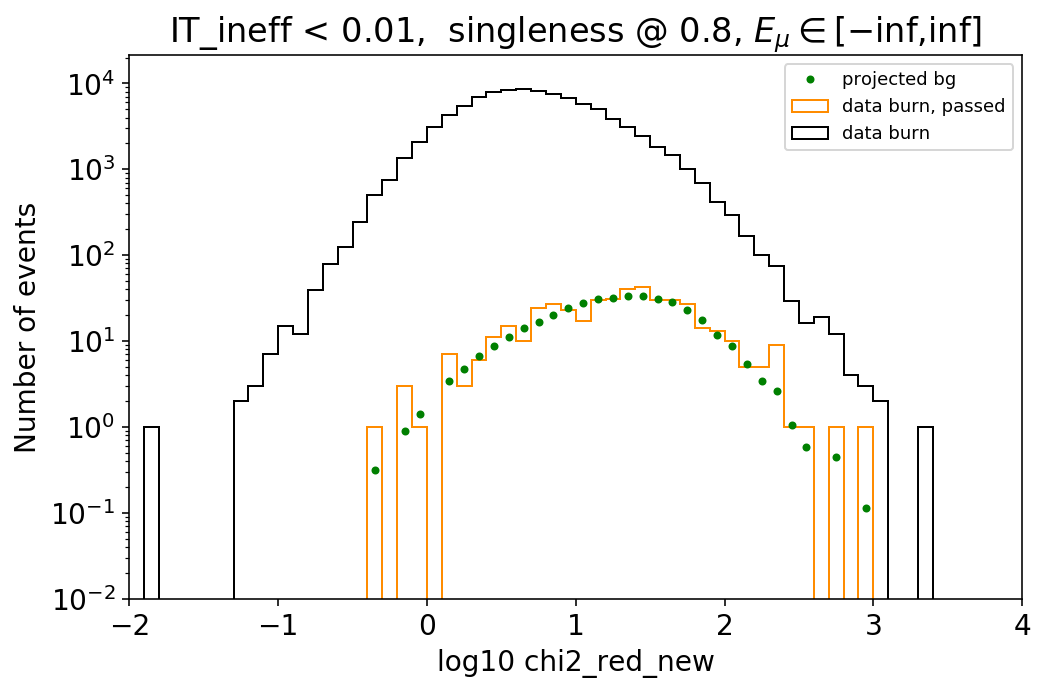

In [9]:
# fitting(0.01,singleness_thres=0.8,truncated_bin=[5.5,6],makeplot=True)
fp_08, popt_08, b_08, h_proj_08 = fitting(0.01,singleness_thres=0.8,makeplot=True)

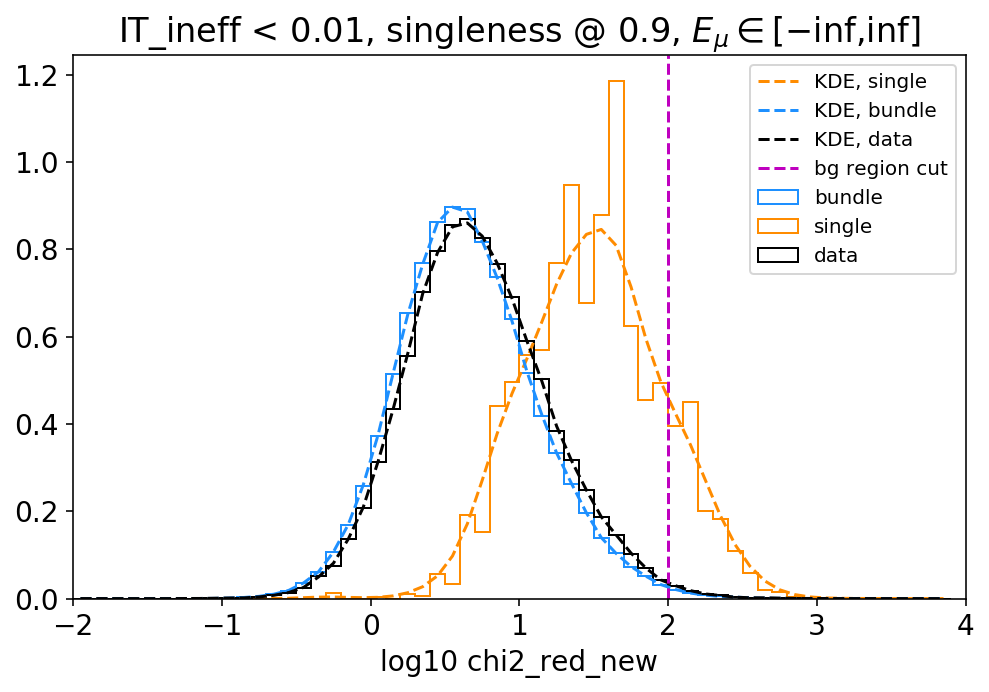

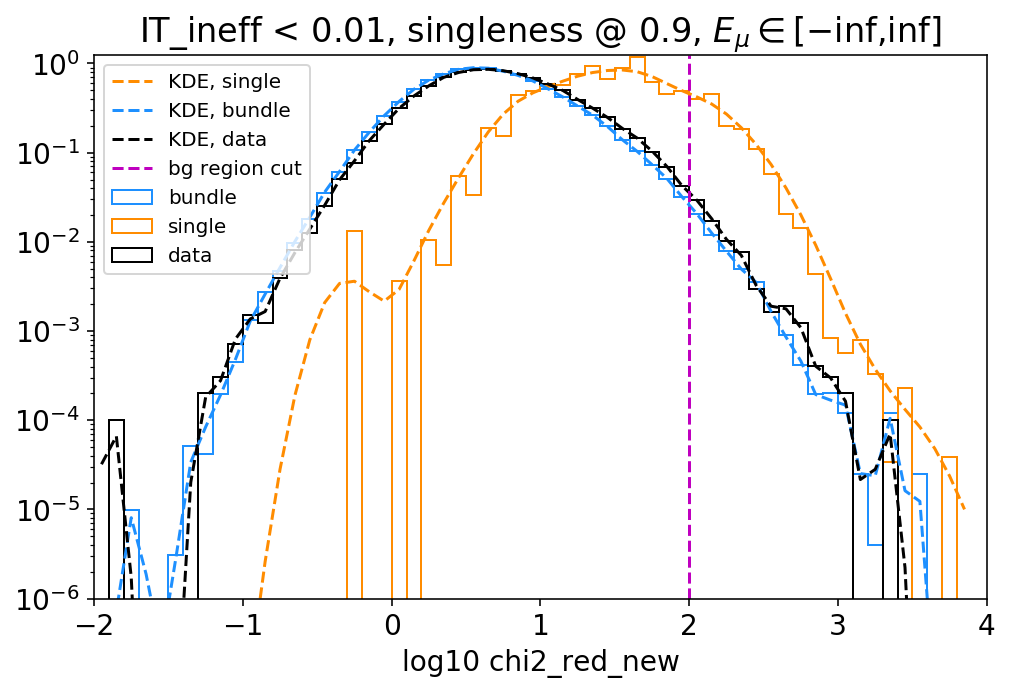

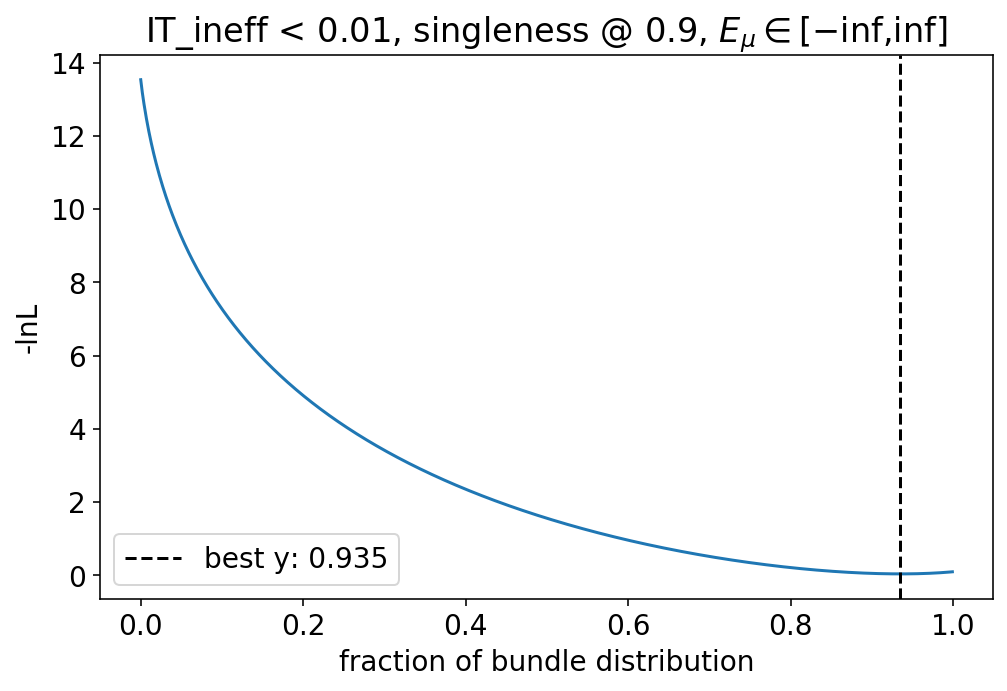

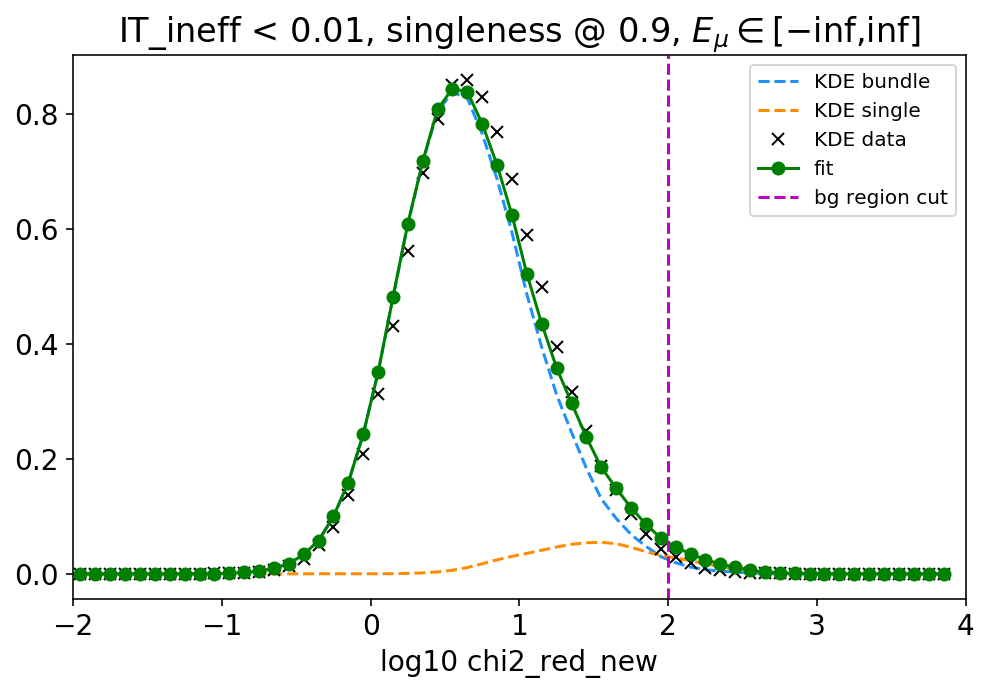

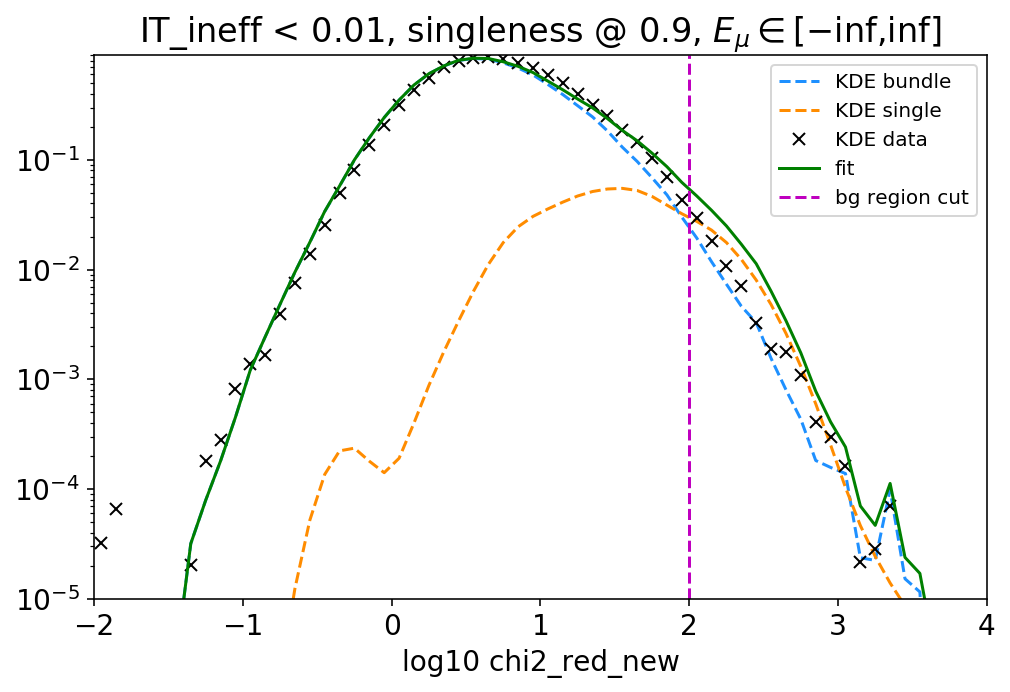

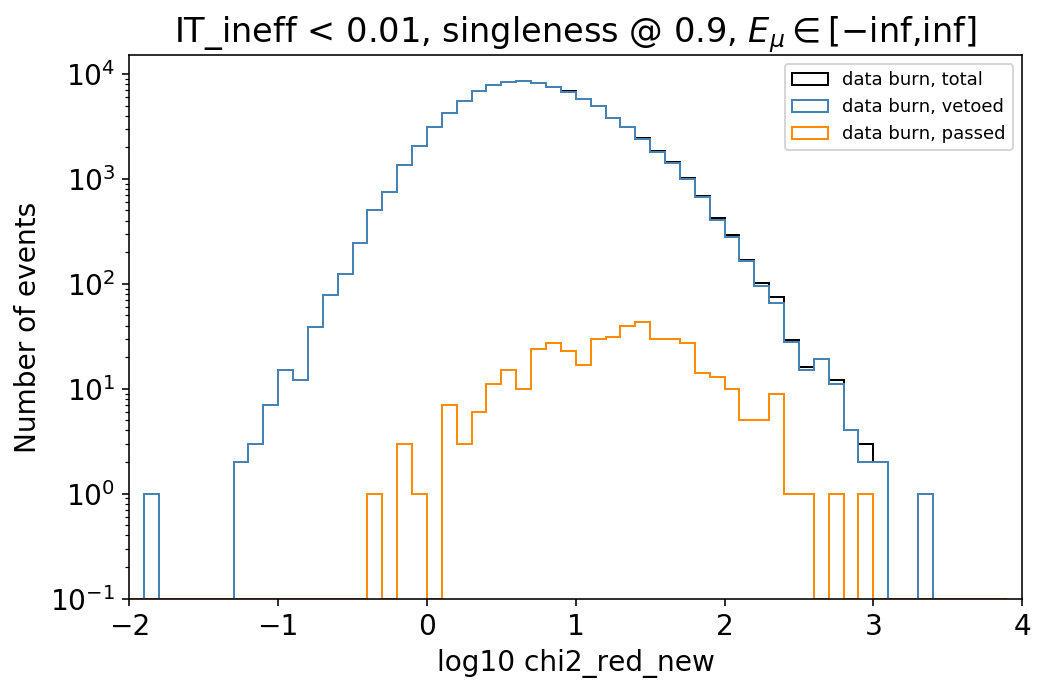

red chisqr val at best-fit: 1.1170158171352955
P_bundle: 0.000819154133320573, P_single: 0.05687000078137277


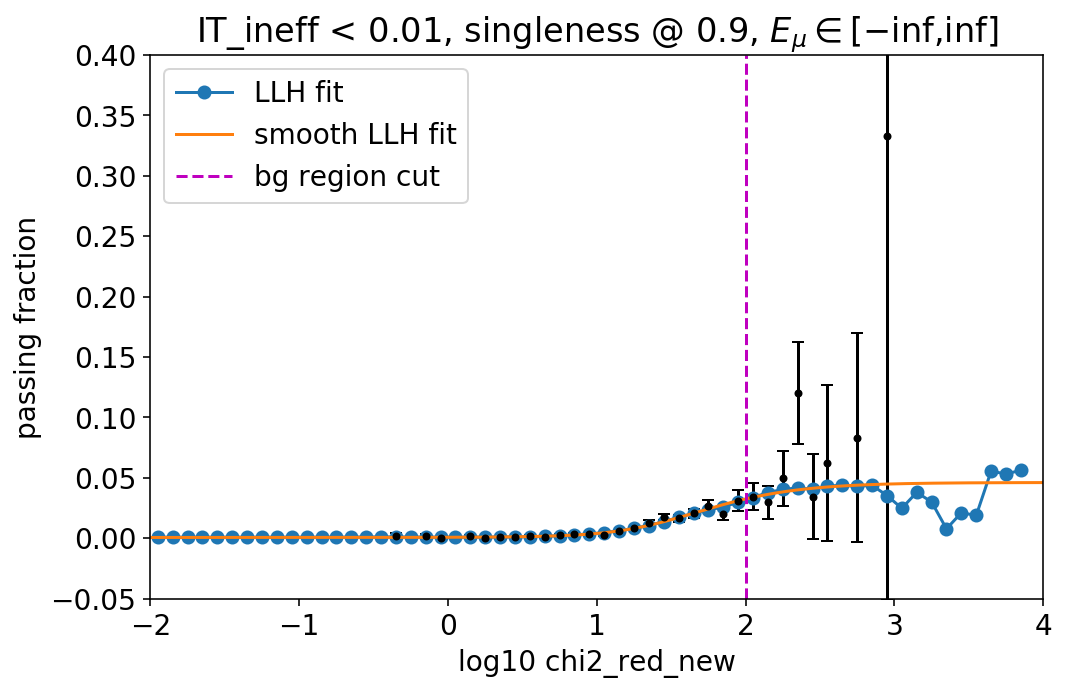

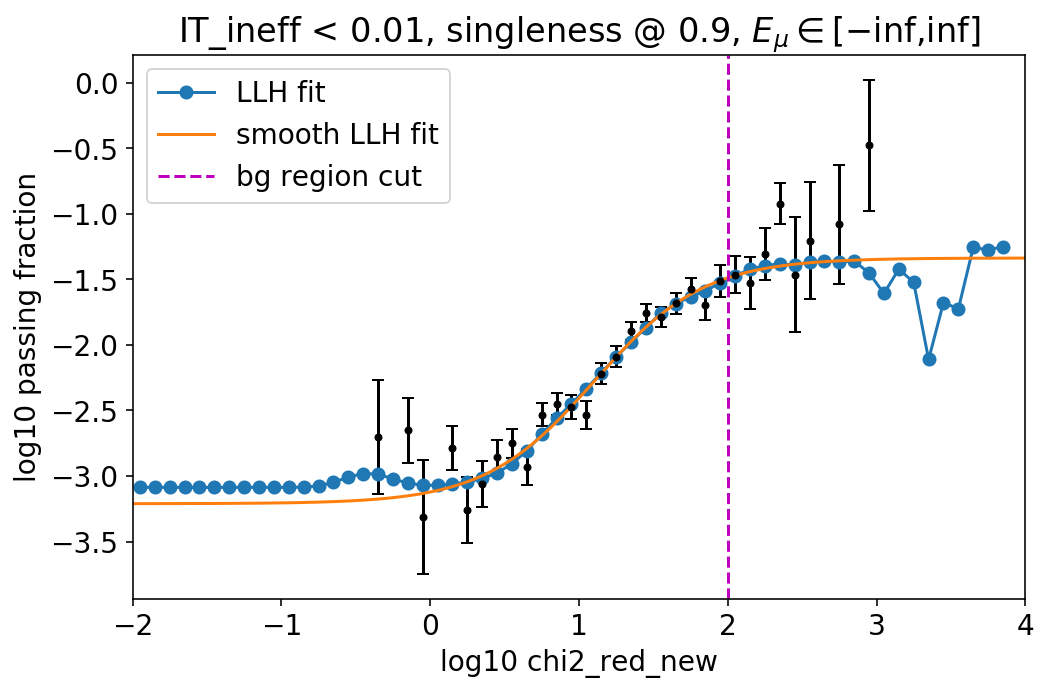

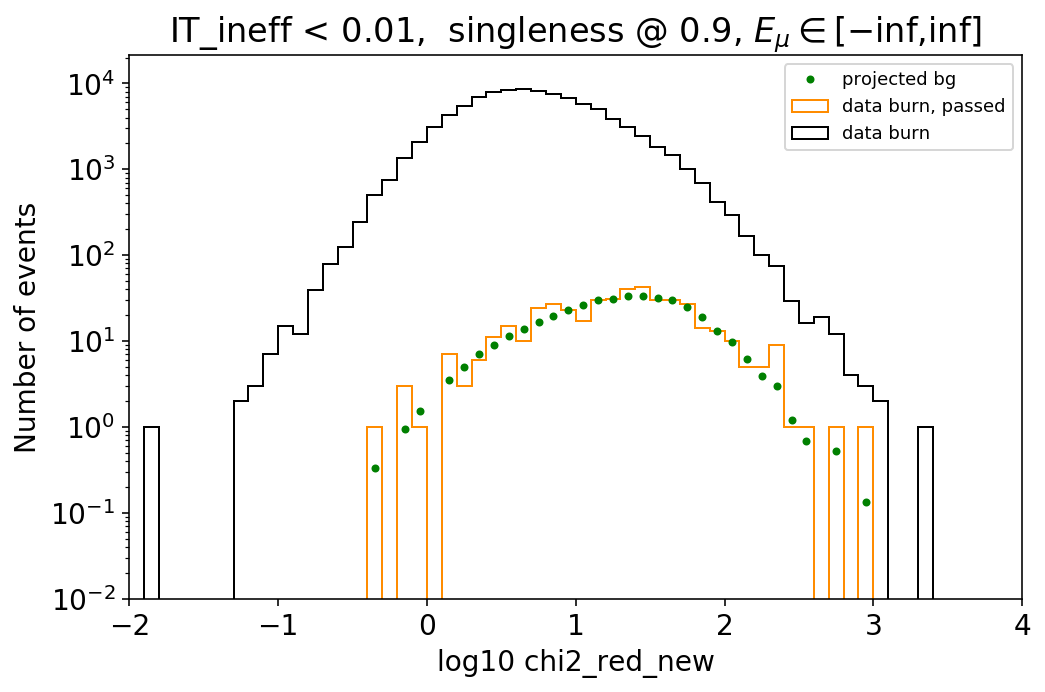

In [10]:
fp_09, popt_09, b_09, h_proj_09 = fitting(0.01,singleness_thres=0.9,makeplot=True)

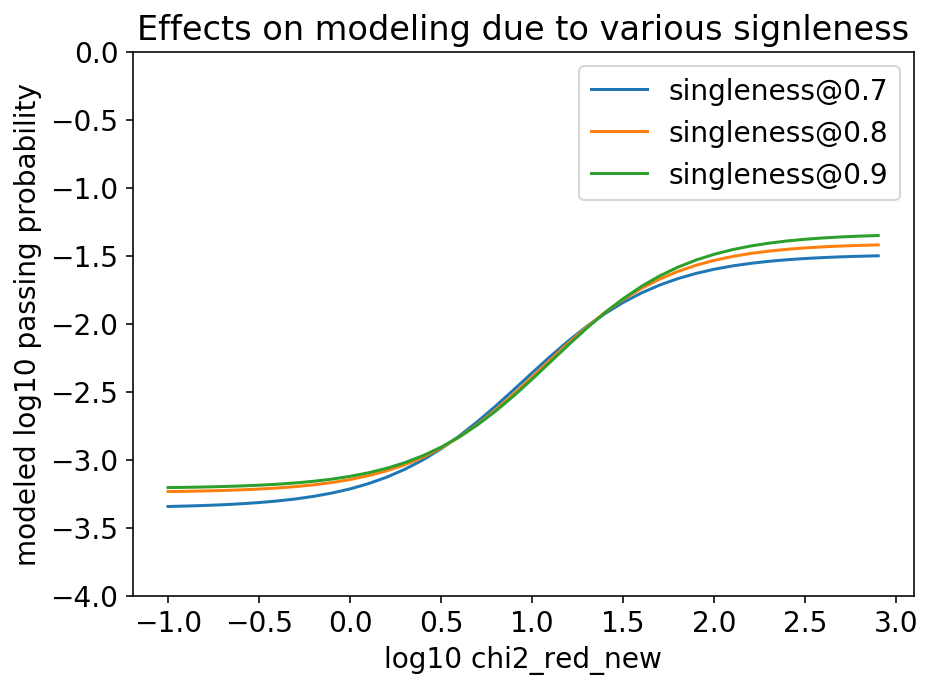

In [11]:
plt.figure(figsize=(7,5))
c = np.arange(-1,3,0.1)
plt.plot(c,fp_07(c,*popt_07),label='singleness@0.7')
plt.plot(c,fp_08(c,*popt_08),label='singleness@0.8')
plt.plot(c,fp_09(c,*popt_09),label='singleness@0.9')
plt.legend()
plt.ylim(-4,0)
plt.xlabel('log10 chi2_red_new')
plt.ylabel('modeled log10 passing probability')
plt.title('Effects on modeling due to various signleness')
plt.show()

In [12]:
b_07

array([-0.35, -0.15, -0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,
        0.75,  0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,
        1.65,  1.75,  1.85,  1.95,  2.05,  2.15,  2.25,  2.35,  2.45,
        2.55,  2.75,  2.95])

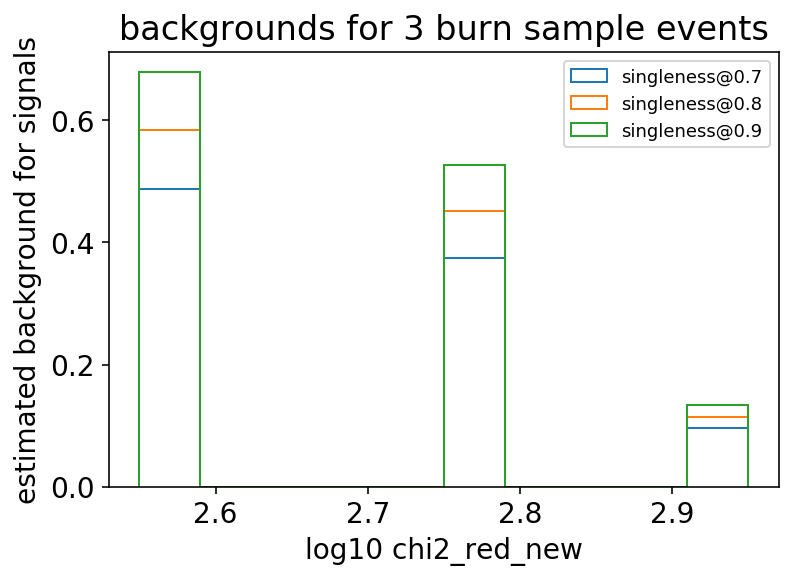

In [13]:
plt.hist(b_07[-3:],weights=h_proj_07[-3:],histtype='step',label='singleness@0.7')
plt.hist(b_08[-3:],weights=h_proj_08[-3:],histtype='step',label='singleness@0.8')
plt.hist(b_09[-3:],weights=h_proj_09[-3:],histtype='step',label='singleness@0.9')
plt.legend(prop={'size':9})
plt.xlabel('log10 chi2_red_new')
plt.ylabel('estimated background for signals')
plt.title('backgrounds for 3 burn sample events')
plt.show()

In [14]:
print(np.round(h_proj_08[-3],2),'+',np.round(h_proj_09[-3]-h_proj_08[-3],2),'-',np.round(h_proj_08[-3]-h_proj_07[-3],2) )
print(np.round(h_proj_08[-2],2),'+',np.round(h_proj_09[-2]-h_proj_08[-2],2),'-',np.round(h_proj_08[-2]-h_proj_07[-2],2) )
print(np.round(h_proj_08[-1],2),'+',np.round(h_proj_09[-1]-h_proj_08[-1],2),'-',np.round(h_proj_08[-1]-h_proj_07[-1],2) )

0.58 + 0.09 - 0.1
0.45 + 0.08 - 0.08
0.11 + 0.02 - 0.02


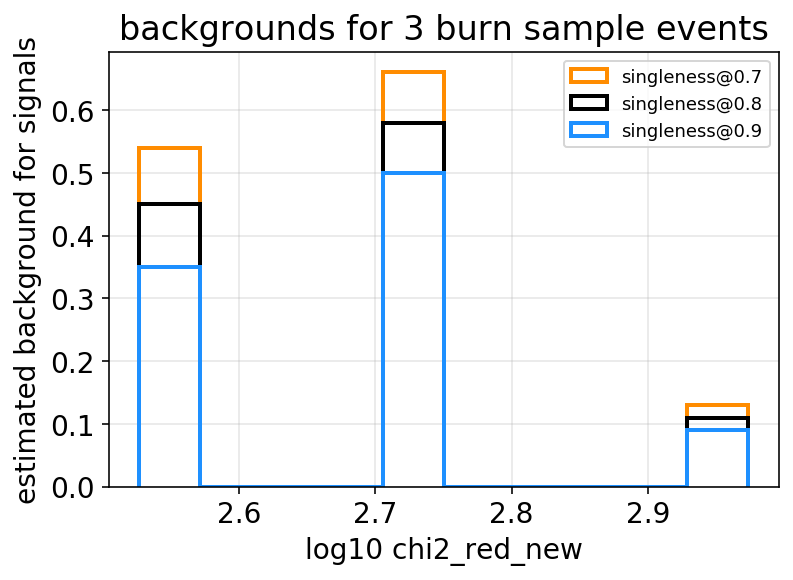

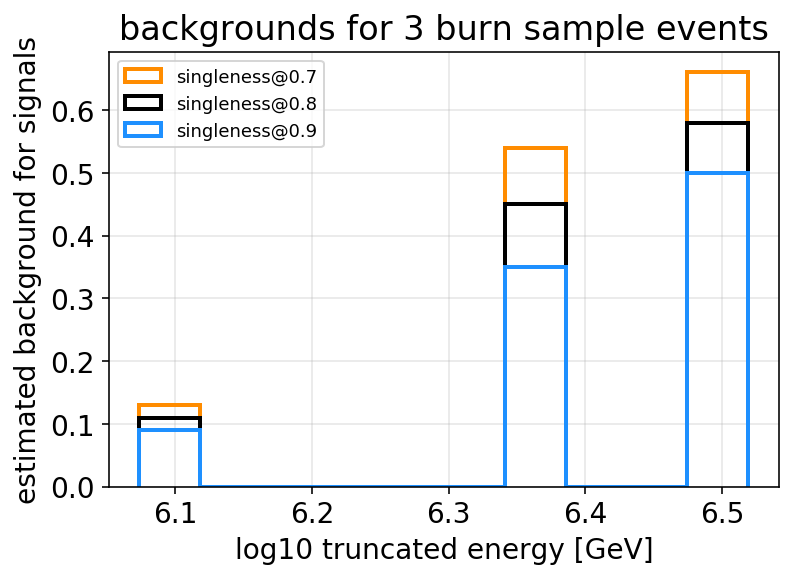

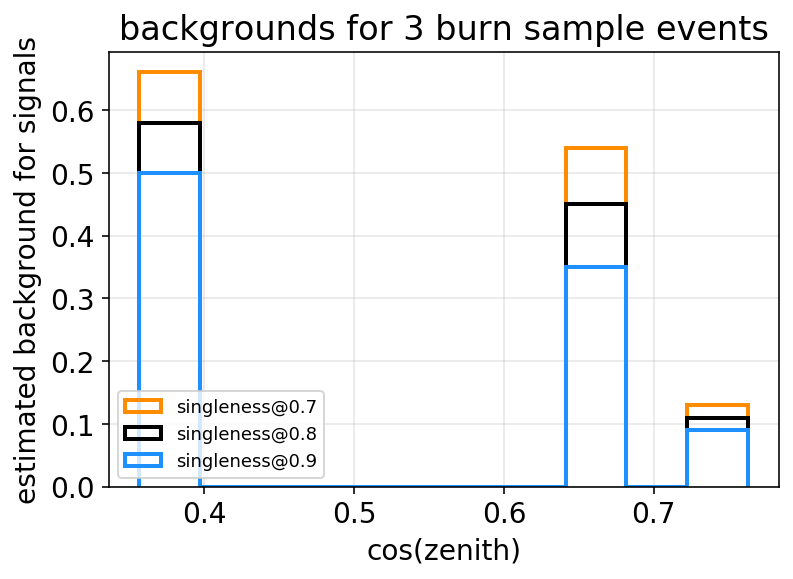

In [15]:
width = (b_08[1] - b_08[0])/4
cut_signal = (np.log10(chi2_red_new_data_burn) > 2.5) & (ineff_data_burn < 0.01) & (passed_2_data_burn)
S = np.log10(chi2_red_new_data_burn[cut_signal])[np.array([1,0,2])]
E = np.log10(truncated_muon_e_data_burn[cut_signal])[np.array([1,0,2])]
Z = np.cos(zenith_data_burn[cut_signal])[np.array([1,0,2])]
B = np.array([0.45, 0.58, 0.11])
up = np.array([0.09, 0.08, 0.02])
down = np.array([0.1,0.08,0.02])

plt.figure()
# plt.errorbar(S, B, yerr=[down,up],xerr=width, fmt='o',capsize=2,label='Estimated background')
plt.hist(S,weights=B+up,histtype='step',lw=2,label='singleness@0.7',color='darkorange')
plt.hist(S,weights=B,histtype='step',lw=2,label='singleness@0.8',color='black')
plt.hist(S,weights=B-down,histtype='step',lw=2,label='singleness@0.9',color='dodgerblue')
plt.legend(prop={'size':9})
plt.xlabel('log10 chi2_red_new')
plt.ylabel('estimated background for signals')
plt.title('backgrounds for 3 burn sample events')
plt.grid(alpha=0.3)

plt.figure()
plt.hist(E,weights=B+up,histtype='step',lw=2,label='singleness@0.7',color='darkorange')
plt.hist(E,weights=B,histtype='step',lw=2,label='singleness@0.8',color='black')
plt.hist(E,weights=B-down,histtype='step',lw=2,label='singleness@0.9',color='dodgerblue')
plt.legend(prop={'size':9},loc='upper left')
plt.xlabel('log10 truncated energy [GeV]')
plt.ylabel('estimated background for signals')
plt.title('backgrounds for 3 burn sample events')
plt.grid(alpha=0.3)
plt.show()

plt.figure()
plt.hist(Z,weights=B+up,histtype='step',lw=2,label='singleness@0.7',color='darkorange')
plt.hist(Z,weights=B,histtype='step',lw=2,label='singleness@0.8',color='black')
plt.hist(Z,weights=B-down,histtype='step',lw=2,label='singleness@0.9',color='dodgerblue')
plt.legend(prop={'size':9},loc='lower left')
plt.xlabel('cos(zenith)')
plt.ylabel('estimated background for signals')
plt.title('backgrounds for 3 burn sample events')
plt.grid(alpha=0.3)
plt.show()

In [22]:
np.linspace(61,62,2,dtype=int)

array([61, 62])

In [24]:
E

array([6.36700443, 6.51890447, 6.07408131])

In [17]:
class bg_estimation:
    def __init__(self):
        self.bg = np.array([0.58, 0.45, 0.11]) # ranged by increasing stochasticity
        self.sigma = np.array([0.09, 0.08, 0.02]) # 1 sigma
        
    def background(self, scale): # number of sigma
        bg = self.bg + scale * self.sigma
        return bg

In [18]:
tosave = bg_estimation()

In [19]:
with open('/Users/yang/Desktop/IceCube/Codes/my_proj/analysis_1_downgoing_neutrino/data/systematics/splines/background_estimation.pkl', 'wb') as output:
    pickle.dump(tosave, output, pickle.HIGHEST_PROTOCOL)